<a href="https://colab.research.google.com/github/aim-msds/msds2023-ml3/blob/main/notebooks/cnn/07_finetuning-huggingface.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" align="left" alt="Open In Colab"/>
</a>

In [ ]:
! pip install transformers datasets timm evaluate


# Fine-tuning Hugging Face Models <a class='tocSkip'>

*Note this is adapted from hugging face's object detection tutorial found [here](https://huggingface.co/docs/transformers/tasks/object_detection)*

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Loading the Dataset

In [ ]:
from datasets import load_dataset

lpod = load_dataset("keremberke/license-plate-object-detection", 'full', split=['train[:10%]', 'validation[:10%]', 'test[:10%]'])
lpod

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset license-plate-object-detection downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___license-plate-object-detection/full/1.0.0/e7740c5ed939eb2184b6f17aee84b3a304e2f46f093835a839bcf19f0ca38ce4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

[Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 618
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 176
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 88
 })]

In [ ]:
lpod_train, lpod_val, lpod_test = lpod

In [ ]:
lpod_train[0]

{'image_id': 1498,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x7F03E85AE370>,
 'width': 472,
 'height': 303,
 'objects': {'id': [1548],
  'area': [6731],
  'bbox': [[169.0, 164.0, 127.0, 53.0]],
  'category': [0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including 

You may notice that the `bbox` field follows the COCO format, which is the format that the DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

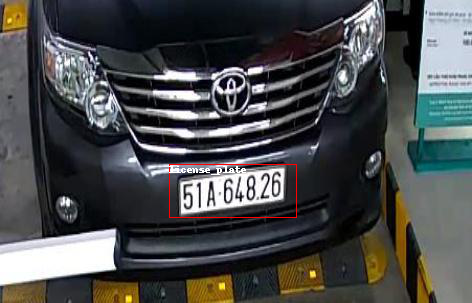

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = lpod_train[0]["image"]
annotations = lpod_train[0]["objects"]
draw = ImageDraw.Draw(image)

categories = lpod_train.features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

## Data Preprocessing

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

In [ ]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)
val_transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480)
    ],
    bbox_params=albumentations.BboxParams(format='coco', label_fields=['category'])
)

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = val_transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
lpod_train = lpod_train.with_transform(transform_aug_ann)
lpod_val = lpod_val.with_transform(transform_ann)
lpod_train[15]

{'pixel_values': tensor([[[ 0.6221,  0.6221,  0.6392,  ..., -0.9363, -0.9363, -0.9363],
          [ 0.6221,  0.6221,  0.6392,  ..., -0.9363, -0.9363, -0.9363],
          [ 0.6221,  0.6221,  0.6392,  ..., -0.9363, -0.9363, -0.9363],
          ...,
          [ 1.1529,  1.1187,  1.0673,  ..., -0.6794, -0.6623, -0.6623],
          [ 1.2043,  1.1015,  0.9817,  ..., -0.6794, -0.6623, -0.6623],
          [ 1.2385,  1.1015,  0.9132,  ..., -0.6794, -0.6623, -0.6623]],
 
         [[ 0.6078,  0.6078,  0.6254,  ..., -0.7402, -0.7402, -0.7402],
          [ 0.6078,  0.6078,  0.6254,  ..., -0.7402, -0.7402, -0.7402],
          [ 0.6078,  0.6078,  0.6254,  ..., -0.7402, -0.7402, -0.7402],
          ...,
          [ 1.4132,  1.3431,  1.2381,  ..., -0.3550, -0.3375, -0.3375],
          [ 1.4657,  1.3782,  1.2556,  ..., -0.3550, -0.3375, -0.3375],
          [ 1.5007,  1.4132,  1.2731,  ..., -0.3550, -0.3375, -0.3375]],
 
         [[ 0.7751,  0.7751,  0.7925,  ..., -0.5321, -0.5321, -0.5321],
          [ 

In [ ]:
lpod_val[15]

{'pixel_values': tensor([[[ 0.3481,  0.3481,  0.3309,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.3481,  0.3481,  0.3309,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.3481,  0.3481,  0.3309,  ..., -0.1314, -0.1314, -0.1314],
          ...,
          [-1.0390, -1.0048, -0.9705,  ...,  0.7248,  0.7591,  0.7933],
          [-1.0390, -1.0048, -0.9705,  ...,  0.8276,  0.8618,  0.8961],
          [-1.0390, -1.0048, -0.9705,  ...,  0.8961,  0.9303,  0.9646]],
 
         [[ 0.3277,  0.3277,  0.3102,  ..., -0.2500, -0.2500, -0.2500],
          [ 0.3277,  0.3277,  0.3102,  ..., -0.2500, -0.2500, -0.2500],
          [ 0.3277,  0.3277,  0.3102,  ..., -0.2500, -0.2500, -0.2500],
          ...,
          [ 1.3256,  1.3256,  1.3081,  ...,  1.0980,  1.1155,  1.1155],
          [ 1.3256,  1.3256,  1.3081,  ...,  1.0805,  1.1331,  1.1506],
          [ 1.3256,  1.3256,  1.3081,  ...,  1.0805,  1.1331,  1.1681]],
 
         [[ 0.4962,  0.4962,  0.4788,  ...,  0.0431,  0.0431,  0.0431],
          [ 

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Finetuning the DETR model

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="lpod-finetune",
    per_device_train_batch_size=8,
    num_train_epochs=20,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    remove_unused_columns=False,
    push_to_hub=False,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=lpod_train,
    eval_dataset=lpod_val,
    tokenizer=image_processor,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Epoch,Training Loss,Validation Loss
1,2.601600,1.192184
2,0.995700,0.880547
3,0.873700,0.785989
4,0.702600,0.732633
5,0.701800,0.707980
6,0.646200,0.680615
7,0.620600,0.671452
8,0.613300,0.689732
9,0.608700,0.678934
10,0.613700,0.678543


TrainOutput(global_step=780, training_loss=0.8448731226798816, metrics={'train_runtime': 1490.7161, 'train_samples_per_second': 4.146, 'train_steps_per_second': 0.523, 'total_flos': 2.9533752258048e+18, 'train_loss': 0.8448731226798816, 'epoch': 10.0})

In [ ]:
trainer.state.log_history

[{'loss': 2.6016,
  'learning_rate': 9.358974358974359e-06,
  'epoch': 0.64,
  'step': 50},
 {'eval_loss': 1.1921837329864502,
  'eval_runtime': 22.4986,
  'eval_samples_per_second': 7.823,
  'eval_steps_per_second': 0.978,
  'epoch': 1.0,
  'step': 78},
 {'loss': 1.1658,
  'learning_rate': 8.717948717948719e-06,
  'epoch': 1.28,
  'step': 100},
 {'loss': 0.9957,
  'learning_rate': 8.076923076923077e-06,
  'epoch': 1.92,
  'step': 150},
 {'eval_loss': 0.880547285079956,
  'eval_runtime': 22.6783,
  'eval_samples_per_second': 7.761,
  'eval_steps_per_second': 0.97,
  'epoch': 2.0,
  'step': 156},
 {'loss': 0.8737,
  'learning_rate': 7.435897435897437e-06,
  'epoch': 2.56,
  'step': 200},
 {'eval_loss': 0.7859890460968018,
  'eval_runtime': 22.5504,
  'eval_samples_per_second': 7.805,
  'eval_steps_per_second': 0.976,
  'epoch': 3.0,
  'step': 234},
 {'loss': 0.7938,
  'learning_rate': 6.794871794871796e-06,
  'epoch': 3.21,
  'step': 250},
 {'loss': 0.7026,
  'learning_rate': 6.15384615

In [ ]:
model.save_pretrained('./detr_finetuned_lpod')

In [ ]:
image_processor.save_pretrained('./detr_finetuned_lpod')

['./detr_finetuned_lpod/preprocessor_config.json']

## Model Evaluation

In [ ]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_annotation_file_images(lpod):
    output_json = {}
    path_output_lpod = f"{os.getcwd()}/lpod/"

    if not os.path.exists(path_output_lpod):
        os.makedirs(path_output_lpod)

    path_anno = os.path.join(path_output_lpod, "lpod_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in lpod:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(lpod["image"], lpod["image_id"]):
        path_img = os.path.join(path_output_lpod, f"{img_id}.png")
        im.save(path_img)

    return path_output_lpod, path_anno

In [ ]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

path_output_lpod, path_anno = save_annotation_file_images(lpod_test)
test_ds_coco_format = CocoDetection(path_output_lpod, im_processor, path_anno)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained('./detr_finetuned_lpod')
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 11/11 [09:13<00:00, 50.36s/it]


Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

<img src='images/coco-evaluation.png' width=750>

## Inference

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("./detr_finetuned_lpod")
model = AutoModelForObjectDetection.from_pretrained("./detr_finetuned_lpod")

img_dirpath = "./01.jpeg"
image = Image.open(img_dirpath)

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.25, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected license_plate with confidence 0.305 at location [21.34, 704.12, 1565.03, 1841.02]
Detected license_plate with confidence 0.259 at location [1769.36, 845.34, 1982.48, 917.09]
Detected license_plate with confidence 0.289 at location [89.26, 714.68, 1561.3, 1854.05]
Detected license_plate with confidence 0.266 at location [694.67, 713.16, 1569.11, 1693.1]
Detected license_plate with confidence 0.283 at location [488.81, 1069.92, 639.37, 1187.5]
Detected license_plate with confidence 0.277 at location [672.29, 700.74, 1575.89, 1845.9]
Detected license_plate with confidence 0.262 at location [486.26, 1064.46, 657.75, 1215.54]
Detected license_plate with confidence 0.265 at location [683.38, 709.64, 1581.14, 1852.39]
Detected license_plate with confidence 0.305 at location [26.01, 685.01, 1583.9, 1856.86]


In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image